In [1]:
# instalar as bibliotecas necessárias
#!pip install numpy pandas matplotlib scikit-learn tabletext scipy seaborn plotly

## Determinar a quantidade de Cluster para o algorítmo K-means

In [2]:
# importar bibliotecas
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

import scipy.stats

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

from IPython.display import display,HTML
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

In [3]:
#configurar tema dos gráficos
sns.set_theme()

In [4]:
def avaliar_opcoes_arranjo(qtd_min_clusters,qtd_max_clusters,dataset):
    # Definir range de clusters
    range_clusters = range(qtd_min_clusters,qtd_max_clusters+1)
    
    # Lista para armazenar os resultados da clusterização para cada arranjo
    resultados=[]
    
    for i,k in enumerate(range_clusters):
        resultado={"arranjo":f"{k} Grupos","qtd_grupos":k }
        
        #print("="*24)
        #print(f"Calculando K-Means para {k } clusters")
        #print("_"*24)
        # Criar um objeto KMeans
        kmeans = KMeans(n_clusters=k)
        
        # Treinar o modelo
        kmeans.fit(dataset)
        # Obter os rótulos dos clusters para cada ponto de dados
        rotulos = kmeans.labels_
        centroides = kmeans.cluster_centers_
        
        resumo_classificacao=[]
        qtd_por_grupos=pd.DataFrame(rotulos).groupby(0)[0].count()
        
        for i,qtd in enumerate(qtd_por_grupos):
            resumo_classificacao.append({"grupo":i+1,"qtd":qtd,"silhueta":0})
    
        # Calcular a silhueta para cada amostra
        silhuetas = silhouette_samples(dados, rotulos)
        
        # Calcular a média da silhueta
        silhueta_media = silhouette_score(dados, rotulos)
        resultado["silhueta_media"]=silhueta_media
    
        
        # Calcular a média da silhueta para cada grupo
        for i in np.unique(rotulos):
            resumo_classificacao[i]["silhueta"]=np.mean(silhuetas[rotulos == i])
            resumo_classificacao[i]["centroides"]=centroides[i]
    
        resultado["resumo_classificacao"]=resumo_classificacao
        resultado["rotulos"]=rotulos
        resultado["silhuetas"]=silhuetas
        resultado["centroides"]=centroides
        #print(resultado)
        
        resultados.append(resultado)
    return resultados

In [5]:
def obter_resultados_validos(resultados,silhueta_corte=0.50):
    # Avaliar resultados de clusterização para cada arranjo
    resultados_validos=[]
    for res in resultados:
        if res["silhueta_media"] >silhueta_corte:
            res["e_valido"]=True
            for grupo in res["resumo_classificacao"]:
                if grupo["silhueta"]<silhueta_corte: # largura da silhueta do grupo
                    res["e_valido"]=False
                    pass
            
            resultados_validos.append(res)
    
    return resultados_validos

In [6]:
def calcular_entropia_1(valores_variavel):
    soma_valores = np.sum(valores_variavel)
    qtd_valores=len(valores_variavel)
    ln = np.log(qtd_valores)
    entropia = (-1/ln)*soma_valores
    #print(soma_valores,qtd_valores,ln,entropia,1-entropia)
    return 1-entropia

In [7]:
def calcular_entropia(valores_variavel):
    unique_values, value_counts = np.unique(valores_variavel, return_counts=True)
    value_probs = value_counts / len(valores_variavel)
    entropy = -np.sum(value_probs * np.log(value_probs + 1e-10))  # Adicionando um pequeno valor para evitar log(0)
    return entropy

In [8]:
def selecionar_melhor_opcao_arranjo(resultados_validos):
    if len(resultados_validos)==0:
        return None
        
    arranjo_selecionado=None
    todos_arranjos_validos=False
    
    menor_grupo = resultados_validos[0]["qtd_grupos"]
    maior_silhueta=resultados_validos[0]["silhueta_media"]
    
    indice_menor_grupo=0
    indice_maior_silhueta=0
    
    for i,res in enumerate(resultados_validos):
        if menor_grupo > res["qtd_grupos"]:
            menor_grupo=res["qtd_grupos"]
            indice_menor_grupo=i
            print(menor_grupo ,res["qtd_grupos"])
            
        if maior_silhueta < res["silhueta_media"]:
            maior_silhueta=res["silhueta_media"]
            indice_maior_silhueta=i
            print(maior_silhueta ,res["silhueta_media"])
    
    if todos_arranjos_validos:
        arranjo_selecionado= resultados_validos[indice_menor_grupo]
    else:
        arranjo_selecionado= resultados_validos[indice_maior_silhueta]
    
    return arranjo_selecionado

In [9]:
def imprimir_dados_arranjo(arranjo):
   
    display(HTML(
    f'''
    <h4> Detalhes do Arranjo</h4>
    <hr>
    <ul>
        <li><b>Arranjo selecionado</b>: {arranjo["arranjo"]}</li>
        <li><b>Qtd. Grupos</b>: {arranjo["qtd_grupos"]}</li>
        <li><b>Silhueta média</b>: {arranjo["silhueta_media"]:.4f}</li>
    </ul>
    <br/>
    <table>
        <tr><th>No.</th><th>Qtd. Registros</th><th>Silhueta</th></tr>
        {   
            '</tr><tr>'.join(
            '<td>{}</td><td>{}</td><td>{}</td>'.format(grupo["grupo"],grupo["qtd"],grupo["silhueta"])
            for grupo in arranjo["resumo_classificacao"])
                
        }
    </table>
    '''
))

In [10]:
def imprimir_grafico_analise_arranjo(arranjo):
    cluster =arranjo
    
    print(
        "For n_clusters =",
        cluster["qtd_grupos"],
        "The average silhouette_score is :",
        cluster["silhueta_media"],
    )
    
    # Criar um gráfico com 1 linha e 2 colunas
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # Gráfico para exibir a silhueta
    # Definir os limites
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(dfArquivo) + (cluster["qtd_grupos"] + 1) * 10])
    
    y_lower = 10
    
    for i in range(cluster["qtd_grupos"]):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = cluster["silhuetas"][cluster["rotulos"] == i]
    
        ith_cluster_silhouette_values.sort()
    
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
    
        color = cm.nipy_spectral(float(i) / cluster["qtd_grupos"])
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
    
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    
    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=cluster["silhueta_media"], color="red", linestyle="--")
    
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    
    
    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster["rotulos"].astype(float) / cluster["qtd_grupos"])
    ax2.scatter(
        dfArquivo.iloc[:, 1], dfArquivo.iloc[:, 2], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )
    
    # Labeling the clusters
    centers = cluster["centroides"]
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )
    
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")
    
    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    
    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        %cluster["qtd_grupos"],
        fontsize=14,
        fontweight="bold",
    )
    
    plt.show()

In [11]:
# abrir dataset com os indicadores
PATH_TO_DATASET="../dataset/in/Data_Exclusao.xlsx"
dfArquivo=pd.read_excel(PATH_TO_DATASET)

dfArquivo.describe()

,Cod_setor,Dm1,Dm2,Dm3,Dm4,Ec1,Ec2,Ec3,Ed1,Ed2,Hs1,Hs2,In1,In2,Ec4,En1
count,1.820000e+02,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000
mean,4.109401e+14,0.431610,0.887090,0.488915,0.641725,0.784223,0.399439,0.047492,0.826507,0.726793,0.931787,0.094983,0.626116,0.066215,0.324932,0.614705
std,5.611264e+01,0.169151,0.137390,0.156343,0.168971,0.165922,0.212845,0.112634,0.222528,0.218411,0.155137,0.184535,0.359213,0.104639,0.160913,0.166016
min,4.109401e+14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.109401e+14,0.315479,0.869618,0.414778,0.546072,0.723584,0.240377,0.000000,0.709033,0.601370,0.929157,0.000000,0.269631,0.030744,0.222536,0.517521
50%,4.109401e+14,0.439072,0.919345,0.503604,0.672838,0.836286,0.359024,0.000000,1.000000,0.775556,1.000000,0.021006,0.835190,0.050509,0.304587,0.653596
75%,4.109401e+14,0.545928,0.961121,0.594699,0.760060,0.900831,0.552608,0.041588,1.000000,0.905793,1.000000,0.091878,0.913846,0.076450,0.404998,0.722988
max,4.109401e+14,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
# Excluir coluna do identificador censitário
dados=dfArquivo.drop(["Cod_setor"],axis=1)

dados = dados.round(1)
dados

,Dm1,Dm2,Dm3,Dm4,Ec1,Ec2,Ec3,Ed1,Ed2,Hs1,Hs2,In1,In2,Ec4,En1
0,0.7,0.9,0.6,0.9,0.9,1.0,1.0,1.0,1.0,1.0,1.0,0.9,0.1,0.5,0.8
1,0.9,0.8,0.6,0.9,0.7,0.9,0.4,1.0,0.9,1.0,1.0,1.0,0.1,0.7,0.9
2,0.7,0.7,0.7,0.9,0.8,0.8,0.1,1.0,1.0,1.0,0.3,0.9,0.1,0.9,0.9
3,0.7,0.9,0.7,0.9,0.9,0.8,0.2,1.0,1.0,1.0,0.5,0.9,0.0,0.9,0.9
4,0.9,0.7,0.7,0.8,0.8,0.7,0.3,0.7,1.0,1.0,0.5,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,0.4,0.9,0.6,0.7,0.8,0.2,0.0,1.0,0.7,1.0,0.0,0.2,0.1,0.3,0.5
178,0.7,1.0,1.0,0.2,1.0,0.5,0.0,1.0,0.4,1.0,0.0,0.0,1.0,0.4,0.3
179,0.1,1.0,0.0,0.2,0.5,0.4,0.0,1.0,0.2,1.0,0.0,0.0,1.0,0.3,0.2
180,0.0,1.0,0.4,0.2,1.0,0.0,0.0,1.0,0.6,1.0,0.0,0.0,0.0,0.1,0.0


<Axes: xlabel='Dm1', ylabel='Count'>

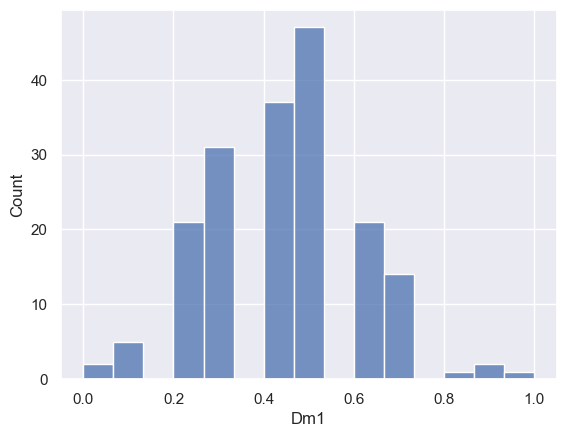

In [13]:
sns.histplot(dados,x="Dm1")

### Avaliar classificação com as sugestões de quantidade ótima de grupos sugerida pelos métodos de avaliação

For n_clusters = 2 The average silhouette_score is : 0.2885087865500227


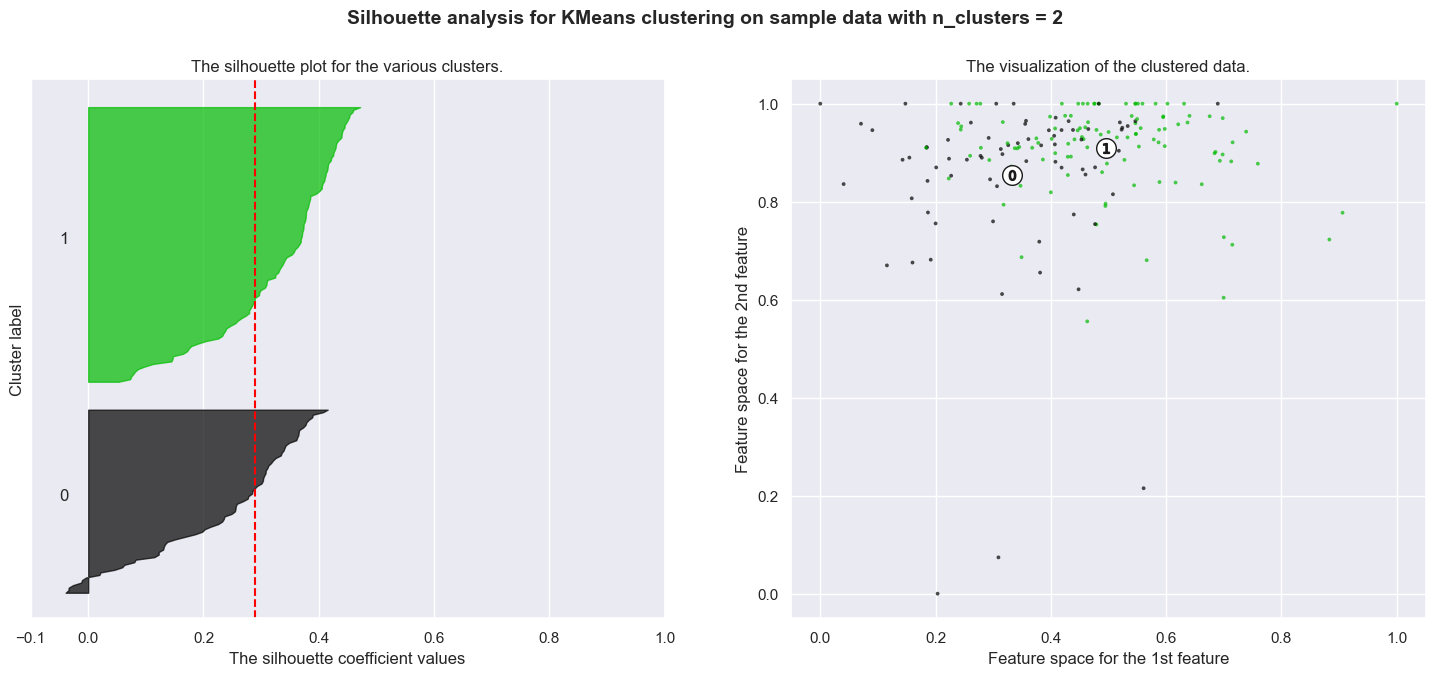

For n_clusters = 8 The average silhouette_score is : 0.13642031301991053


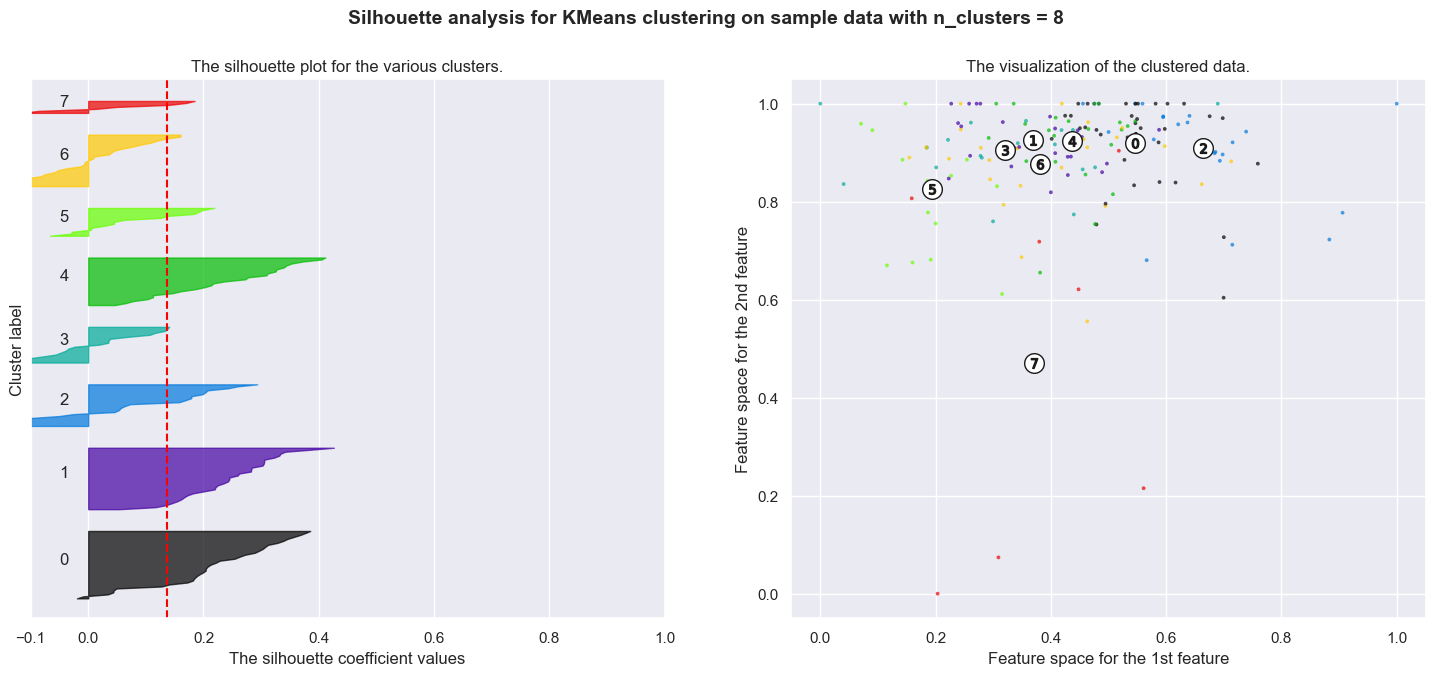

For n_clusters = 13 The average silhouette_score is : 0.14381301592565704


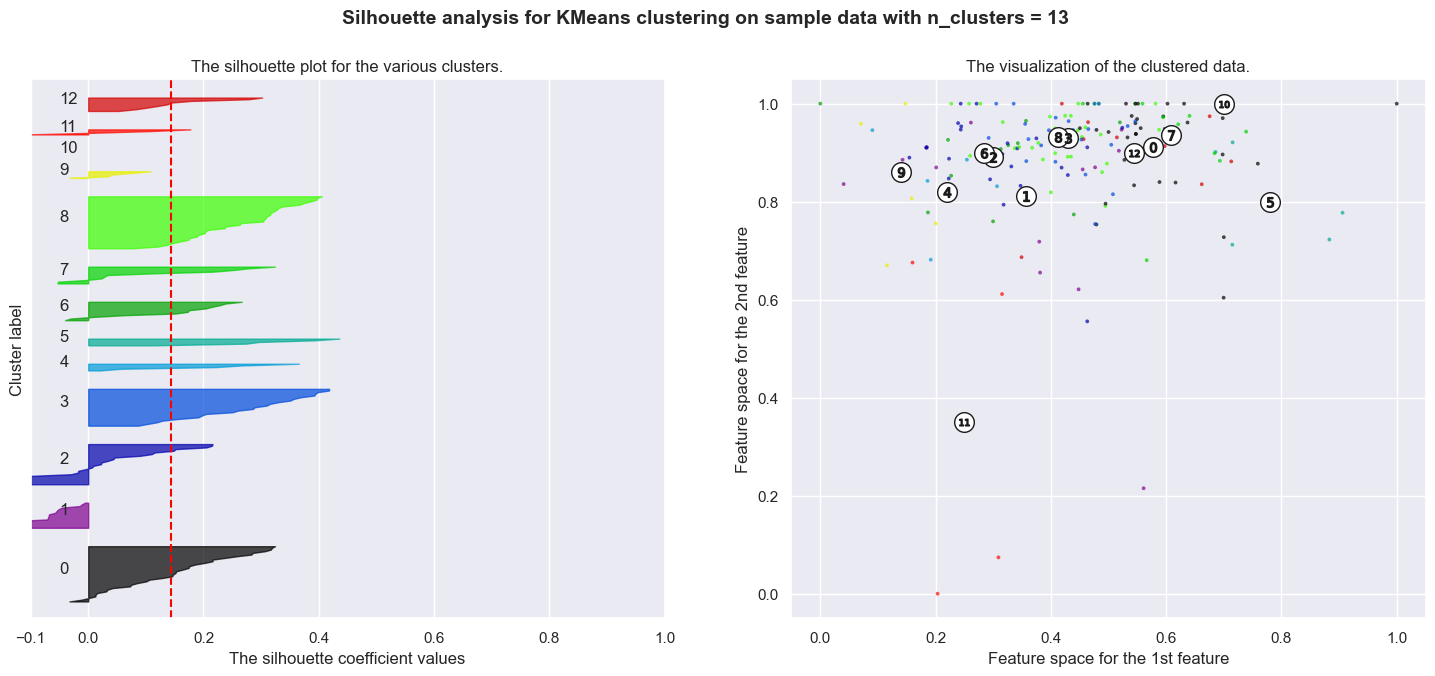

In [14]:

# Obter classificação com a quantidade de clusters sugerida pelos métodos seleção
sugestoes_clusters=[2,8,13]
for k in sugestoes_clusters:
    classificacao=avaliar_opcoes_arranjo(k,k,dados)
    imprimir_grafico_analise_arranjo(classificacao[0])

In [15]:
# definir o range de clusters que serão avaliados
QTD_MIN_CLUSTERS=3
QTD_MAX_CLUSTERS=7

# Gerar dados sintéticos para classificação
# X=pd.DataFrame( np.random.rand(10000, 9))


# Resultado da avaliação 
resultados_pre_otimizacao= avaliar_opcoes_arranjo(QTD_MIN_CLUSTERS,QTD_MAX_CLUSTERS,dados)
resultados_validos=obter_resultados_validos(resultados_pre_otimizacao)

resultados_validos

[]

For n_clusters = 3 The average silhouette_score is : 0.22463851455860387


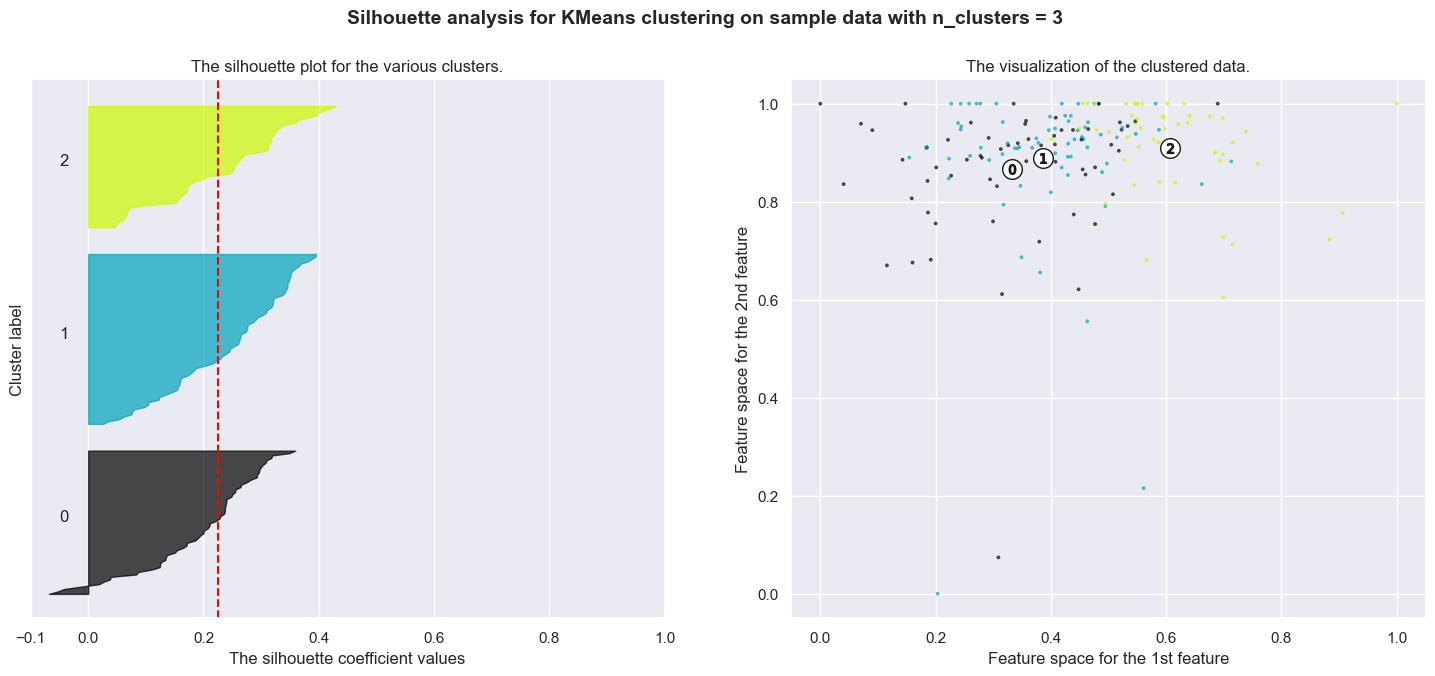

For n_clusters = 4 The average silhouette_score is : 0.16707431539100653


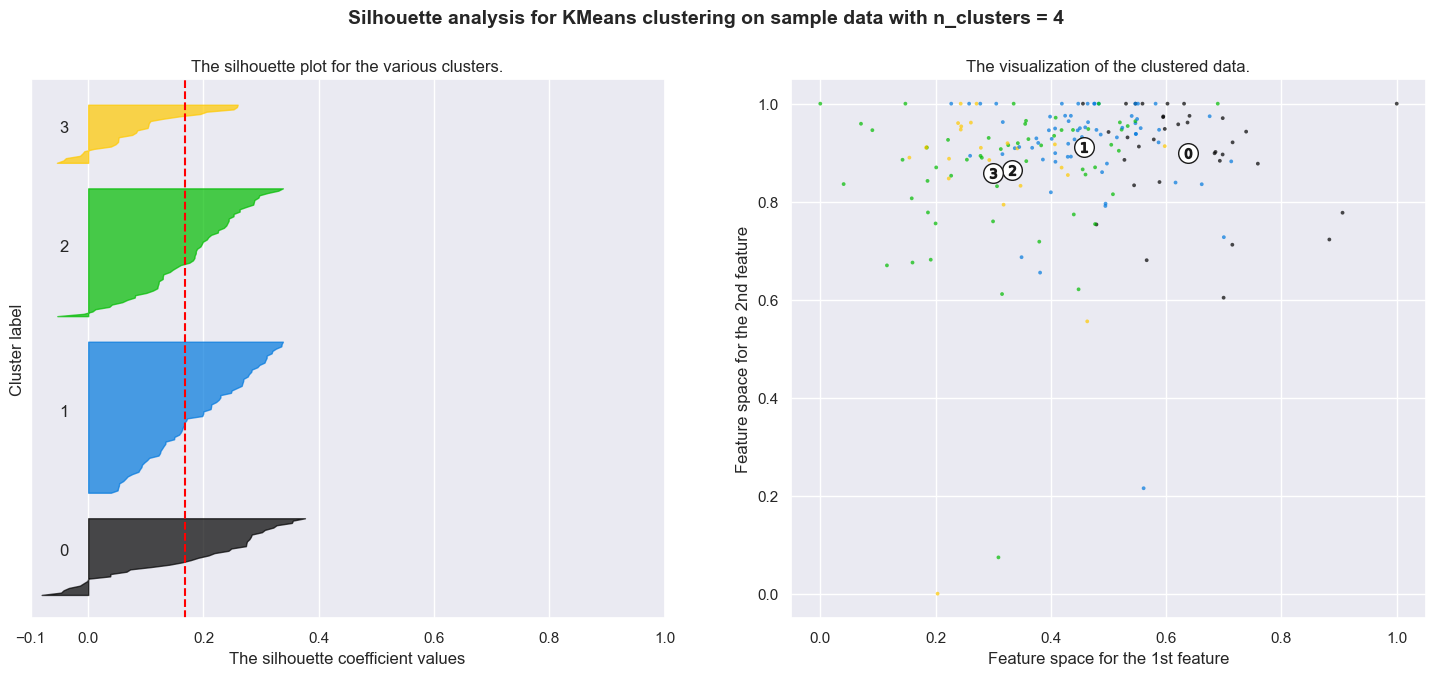

For n_clusters = 5 The average silhouette_score is : 0.1770161479535014


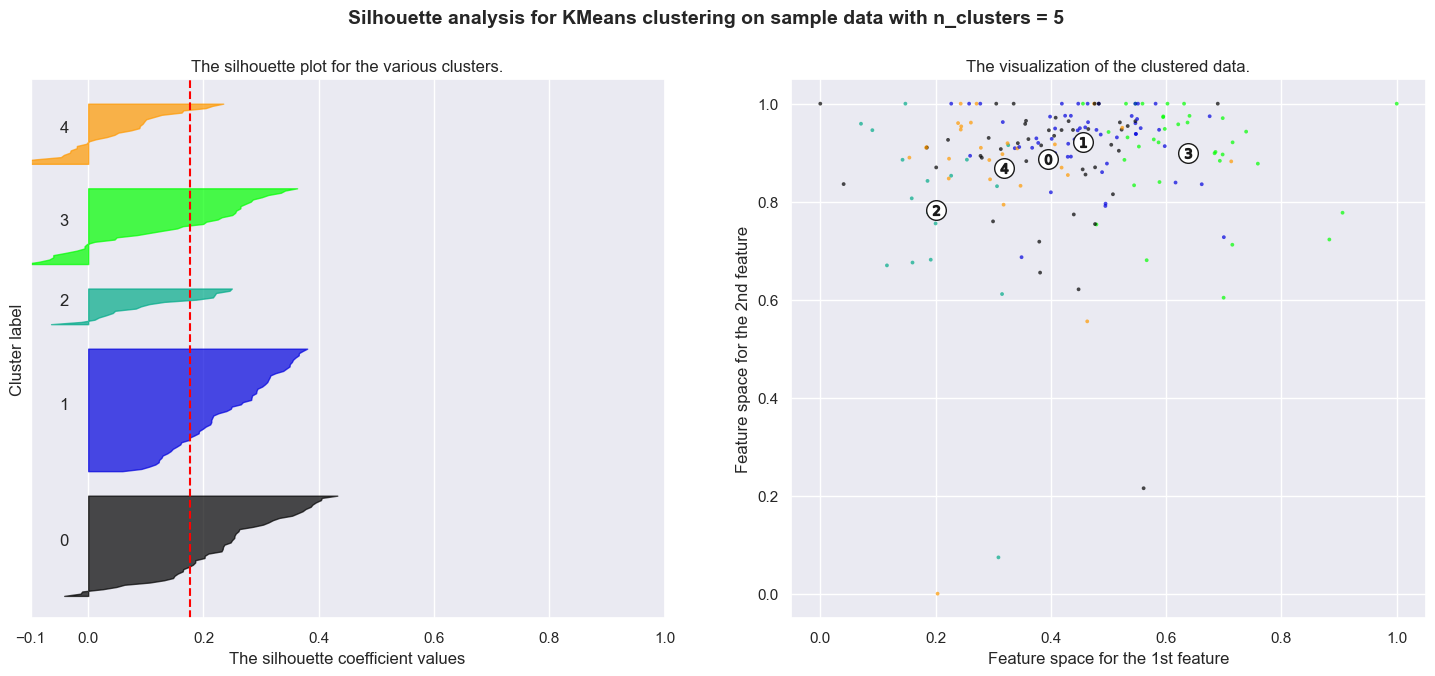

For n_clusters = 6 The average silhouette_score is : 0.17360062782736263


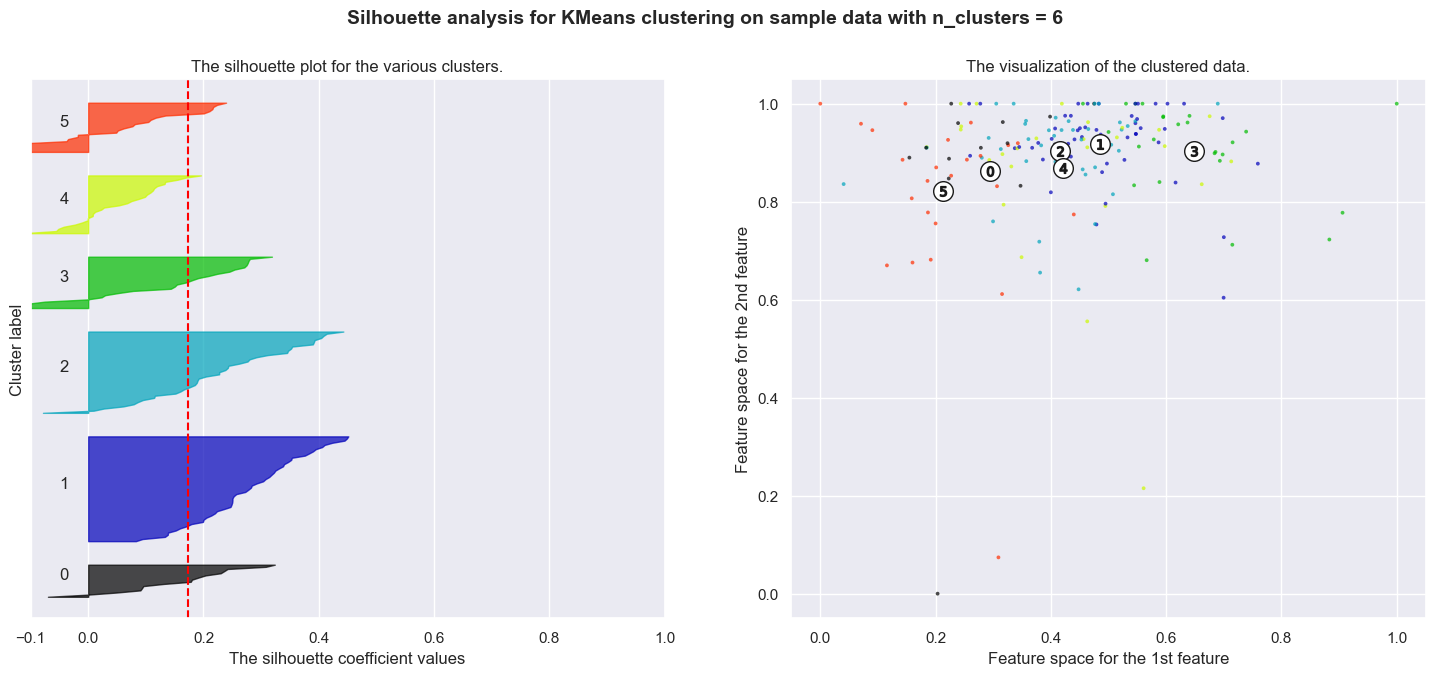

For n_clusters = 7 The average silhouette_score is : 0.1372513994089225


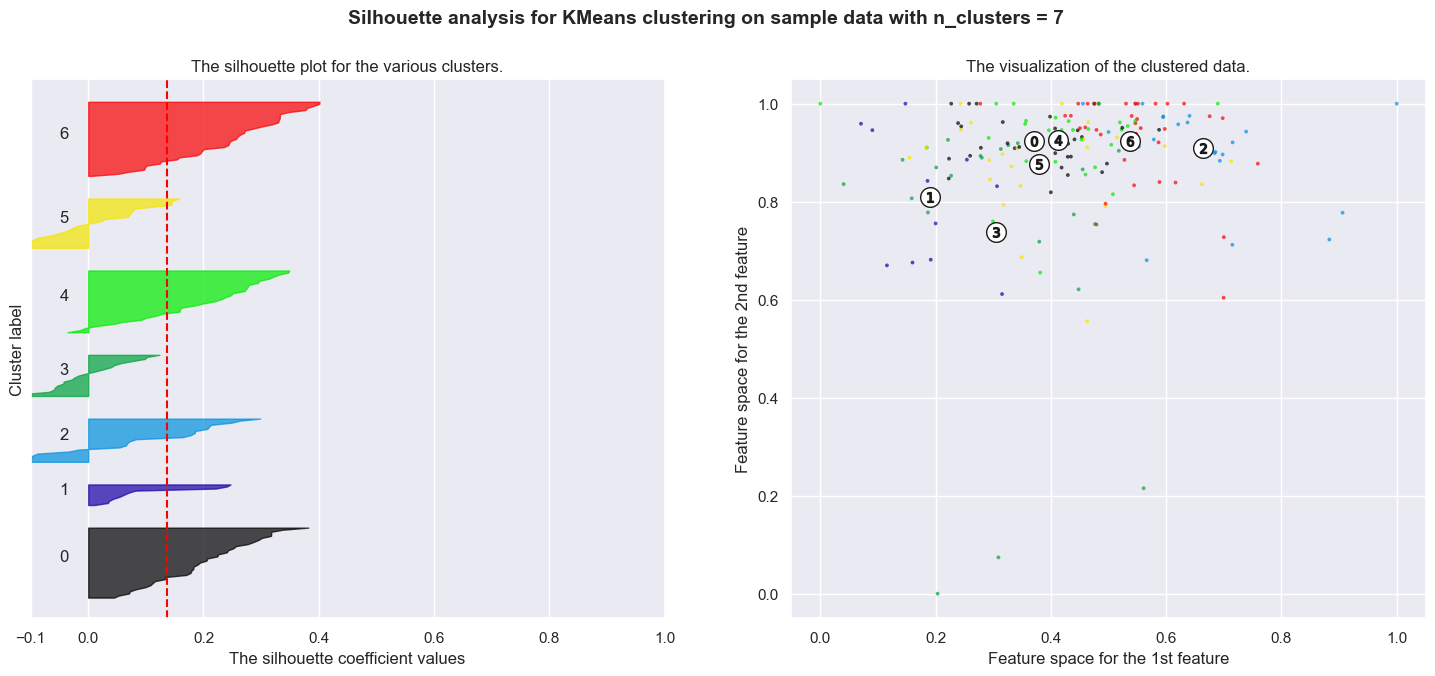

In [16]:
for arranjo in resultados_pre_otimizacao:
    imprimir_grafico_analise_arranjo(arranjo)
    

### Avaliação da Entropia das variáveis do dataset

<Axes: xlabel='entropia', ylabel='variavel'>

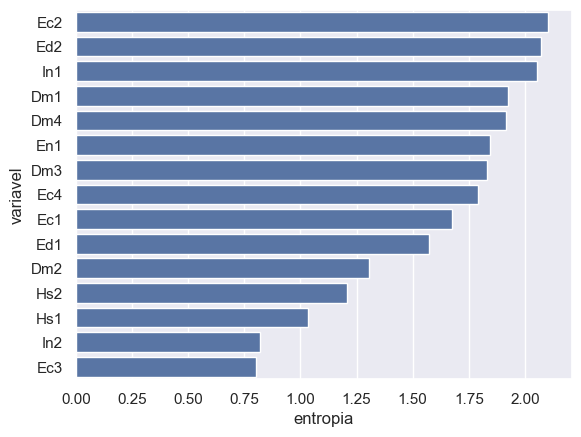

In [17]:
entropias = []

for col in range(dados.shape[1]):
    entropias.append({"variavel":dados.columns[col],"entropia":calcular_entropia(dados.iloc[:,col])})

dfEntropias = pd.DataFrame(entropias)
dfEntropias.sort_values(by=["entropia"],ascending=False,inplace=True)

sns.barplot(dfEntropias,y="variavel",x="entropia")


In [18]:
dfEntropias

,variavel,entropia
5,Ec2,2.103901
8,Ed2,2.073316
11,In1,2.052920
0,Dm1,1.925704
3,Dm4,1.913788
14,En1,1.845282
2,Dm3,1.831871
13,Ec4,1.792483
4,Ec1,1.677028
7,Ed1,1.574049


In [19]:

resultados_validos=[]

melhor_arranjo=selecionar_melhor_opcao_arranjo(resultados_validos)

i_entropia=0
iteracao=1

sumario_iteracoes=[]

while melhor_arranjo is None:
    qtd_variaveis=dados.shape[1]
    if qtd_variaveis < 3:
        print(f"{iteracao} - SEM RESULTADOS VÁLIDOS: Dataset após a exclusão das variáveis não encontrou um resultado.")
        break
        
    #print(f"{iteracao} - SEM RESULTADOS VÁLIDOS: Analisar a entropia das variáveis.")

    #ajustar o nome da variável
    menor_entropia=dfEntropias.iloc[i_entropia]
    
    #print(f"Excluir a variável '{menor_entropia['variavel']}' do dataset ")
    
    # Excluir varíavel com menor entropia
    dados=dados.drop([menor_entropia["variavel"]],axis=1)
    
    # Refazer o K-means utilizando o novo dataset sem a variável com a menor entropia
    resultados= avaliar_opcoes_arranjo(QTD_MIN_CLUSTERS,QTD_MAX_CLUSTERS,dados)
    resultados_validos=obter_resultados_validos(resultados)
    
    melhor_arranjo=selecionar_melhor_opcao_arranjo(resultados_validos)

    dados_iteracao = {"iteracao":iteracao,
                     "resultados_validos":len(resultados_validos),
                     "variavel_excluida":menor_entropia["variavel"],
                     "entropia":menor_entropia["entropia"]
                     }

    sumario_iteracoes.append(dados_iteracao)
    
    i_entropia+=1
    iteracao+=1
    
display(HTML(f'<h3> \o/ Melhor arranjo encontrado após {iteracao-1} iterações!</h3>'))

imprimir_dados_arranjo(melhor_arranjo)

0.5545272093664871 0.5545272093664871


For n_clusters = 4 The average silhouette_score is : 0.5545272093664871


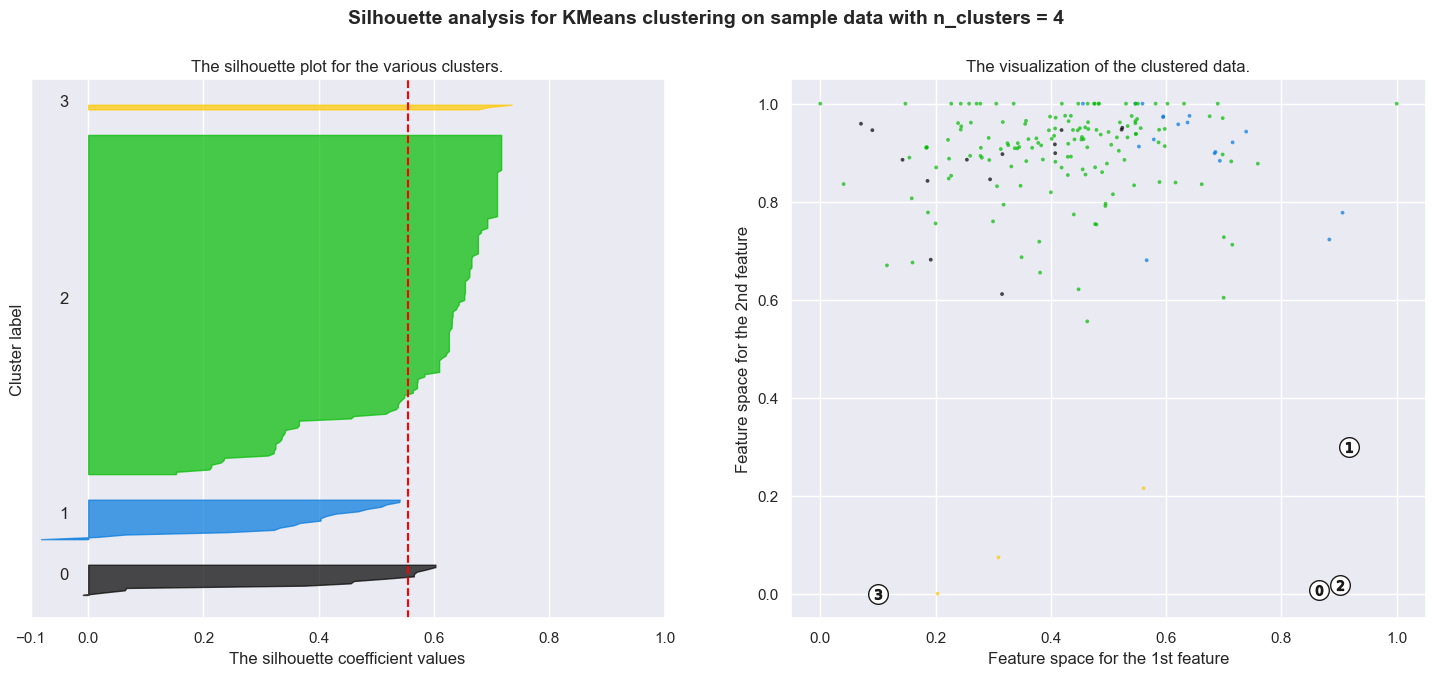

In [20]:
imprimir_grafico_analise_arranjo(melhor_arranjo)

In [21]:
# Ver detalhes das iterações da análise de entropia
df_iteracoes=pd.DataFrame(sumario_iteracoes)
df_iteracoes

,iteracao,resultados_validos,variavel_excluida,entropia
0,1,0,Ec2,2.103901
1,2,0,Ed2,2.073316
2,3,0,In1,2.052920
3,4,0,Dm1,1.925704
4,5,0,Dm4,1.913788
5,6,0,En1,1.845282
6,7,0,Dm3,1.831871
7,8,0,Ec4,1.792483
8,9,0,Ec1,1.677028
9,10,3,Ed1,1.574049


In [22]:
# Variáveis restantes após otimização
dados

,Dm2,Ec3,Hs1,Hs2,In2
0,0.9,1.0,1.0,1.0,0.1
1,0.8,0.4,1.0,1.0,0.1
2,0.7,0.1,1.0,0.3,0.1
3,0.9,0.2,1.0,0.5,0.0
4,0.7,0.3,1.0,0.5,0.0
...,...,...,...,...,...
177,0.9,0.0,1.0,0.0,0.1
178,1.0,0.0,1.0,0.0,1.0
179,1.0,0.0,1.0,0.0,1.0
180,1.0,0.0,1.0,0.0,0.0


In [23]:
# Ver os resultados válidos ao final das análises
[imprimir_dados_arranjo(r) for r in resultados_validos]

[None, None, None]

In [24]:
[imprimir_dados_arranjo(r) for r in resultados]

[None, None, None, None, None]

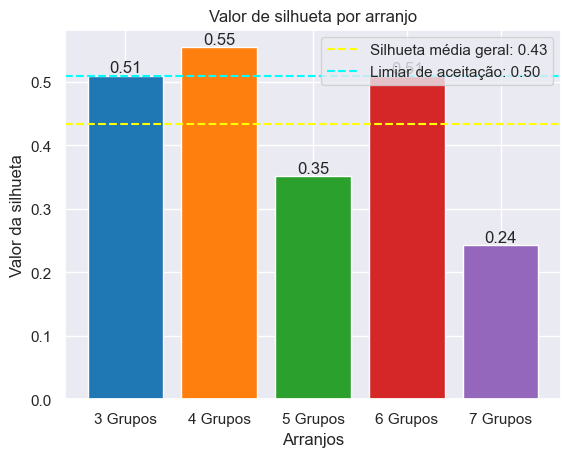

In [25]:

silhuetas=[r["silhueta_media"]for r in resultados]
nomes_arranjo=[r["arranjo"]for r in resultados]

silhueta_media_geral = np.mean(silhuetas)

cores = [a[0] for a in mcolors.TABLEAU_COLORS.items()][:len(nomes_arranjo)]

fig, ax = plt.subplots()
bar_container = ax.bar(nomes_arranjo, silhuetas,color=cores)

# Adicionar uma linha para indicar a média geral da silhueta
ax.axhline(y=silhueta_media_geral, color='yellow', linestyle='--', label=f'Silhueta média geral: {silhueta_media_geral:.2f}')

# Adicionar uma linha para indicar a média geral da silhueta
ax.axhline(y=0.51, color='cyan', linestyle='--', label=f'Limiar de aceitação: {0.50:.2f}')

# Adicionar legenda para as linhas
ax.legend()

ax.set(ylabel='Valor da silhueta', title='Valor de silhueta por arranjo',xlabel="Arranjos")
ax.bar_label(bar_container, fmt='{:,.2f}')

plt.show()

### Salvar arquivo com resultado da classificação

In [26]:
dfClassificacao=dfArquivo[["Cod_setor"]]

dfArquivo["Grupo"]=pd.Series(melhor_arranjo["rotulos"])

# dfArquivo.to_csv("dataset_classificado.csv",sep=";")
dfArquivo

,Cod_setor,Dm1,Dm2,Dm3,Dm4,Ec1,Ec2,Ec3,Ed1,Ed2,Hs1,Hs2,In1,In2,Ec4,En1,Grupo
0,410940105000001,0.693124,0.883441,0.570118,0.920326,0.940887,1.000000,1.000000,1.000000,0.984436,1.000000,1.000000,0.911949,0.069303,0.485336,0.819315,1
1,410940105000002,0.906000,0.777440,0.568458,0.907551,0.723362,0.880554,0.418279,1.000000,0.933081,1.000000,0.956108,0.969708,0.086990,0.675887,0.933910,1
2,410940105000003,0.714812,0.712126,0.727527,0.870477,0.816013,0.813366,0.093626,1.000000,0.988700,1.000000,0.291103,0.889530,0.070139,0.869780,0.908084,2
3,410940105000004,0.685600,0.901545,0.749280,0.911010,0.890011,0.839647,0.189392,1.000000,0.986343,1.000000,0.452706,0.944219,0.047353,0.872219,0.919209,1
4,410940105000005,0.883110,0.722763,0.712888,0.786313,0.816978,0.744081,0.280399,0.650567,1.000000,1.000000,0.451960,1.000000,0.041789,1.000000,1.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,410940105000188,0.405701,0.934455,0.636249,0.697463,0.820363,0.222199,0.000000,1.000000,0.673281,1.000000,0.000000,0.199997,0.073957,0.268284,0.538857,2
178,410940105000189,0.689523,1.000000,1.000000,0.154858,1.000000,0.451993,0.000000,1.000000,0.372557,1.000000,0.000000,0.000000,1.000000,0.435096,0.255244,2
179,410940105000190,0.147641,1.000000,0.000000,0.229461,0.541156,0.390893,0.000000,1.000000,0.173626,1.000000,0.000000,0.000000,1.000000,0.269255,0.187330,2
180,410940105000191,0.000000,1.000000,0.435858,0.198216,1.000000,0.000000,0.000000,1.000000,0.566473,1.000000,0.000000,0.000000,0.044780,0.105261,0.000000,2


In [27]:
dados=zip(melhor_arranjo['rotulos'],melhor_arranjo['silhuetas'])

df=pd.DataFrame(dados)

df

,0,1
0,1,0.356589
1,1,0.483321
2,2,0.210010
3,1,0.429685
4,1,0.367297
...,...,...
177,2,0.716364
178,2,0.152427
179,2,0.152427
180,2,0.664844


In [28]:
cluster=melhor_arranjo
df = pd.DataFrame(zip(cluster["silhuetas"],cluster["rotulos"]),columns=["silhuetas","rotulos"])
df.sort_values(by=["rotulos","silhuetas"],inplace=True)
rotulos = list(df.groupby(["rotulos"]).count().index)
rotulos
melhor_arranjo["silhueta_media"]

0.5545272093664871

In [29]:
rotulos

[0, 1, 2, 3]

In [30]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly import data

rows,cols = df.shape

fig = make_subplots(rows=1, cols=len(rotulos), shared_yaxes=True)

for rotulo in rotulos:
    fig.add_trace(
        go.Bar(y=df["silhuetas"][df["rotulos"]==rotulo], name=f"Grupo {rotulo}"), 1, rotulo+1
    )
# fig.add_trace(
#     go.Bar(y=df["silhuetas"][df["rotulos"]==1], name="2"),
#     1,
#     2,
# )

# fig.add_trace(
#     go.Bar(y=df["silhuetas"][df["rotulos"]]==2, name="3"),
#     1,
#     3,
# )

fig.add_hline(y=cluster["silhueta_media"],
                  line_width=2,
                  line_dash="dash",
                  line_color="red")

fig.show()

In [31]:
df_1=df.groupby("rotulos",as_index=False).count()
df_1

,rotulos,silhuetas
0,0,14
1,1,18
2,2,147
3,3,3


In [32]:
df=df.groupby("rotulos").count()
fig = px.bar(df_1, y="silhuetas",x="rotulos", color="rotulos")
fig

In [33]:
resumo = pd.DataFrame(cluster["resumo_classificacao"])         
resumo["nome_grupo"] = "G"+(resumo["grupo"]).astype(str)      
resumo["nome_grupo"]

0    G1
1    G2
2    G3
Name: nome_grupo, dtype: object

In [34]:
fig = px.bar(resumo, x="nome_grupo", y="qtd", color="nome_grupo")  
fig

In [33]:
silhuetas=[r["silhueta_media"]for r in resultados]
nomes_arranjo=[r["arranjo"]for r in resultados]

df=pd.DataFrame({'arranjo':nomes_arranjo,'silhueta_media':silhuetas})


fig = px.bar(df, x="arranjo", y="silhueta_media", color="arranjo")  

fig.add_hline(y=df["silhueta_media"].mean(),
              line_width=2,          
              line_dash="dash",      
              line_color="cyan",
              annotation_text="Silhueta média geral") 

fig.add_hline(y=0.5,
              line_width=2,          
              line_dash="dash",      
              line_color="yellow",
              annotation_text="Limiar de aceitação")   

fig



In [34]:
colunas_excluidas=df_iteracoes["variavel_excluida"].values
colunas_excluidas = np.append(colunas_excluidas,"Cod_setor")
novo_df_arquivo = dfArquivo.drop(colunas_excluidas,axis=1)
cols = novo_df_arquivo.columns
dados_anova=[]

for grupo in novo_df_arquivo["Grupo"].unique():
    anova = novo_df_arquivo[novo_df_arquivo["Grupo"]==grupo].describe().round(3)
    dados_anova.append(np.append(anova.iloc[[1]].values[0][:-1],f"G{grupo}"))
    # for i,col in enumerate(cols[1::]):
    #     dados_anova.append({"grupo":f"G{grupo}" ,"variavel":col,"media":anova.iloc[[1]].values[0][i]})

df_variaveis=pd.DataFrame(dados_anova,columns=cols).round(2)

In [35]:
df_variaveis

,Dm2,Ec3,Hs1,Hs2,In2,Grupo
0,0.912,0.304,0.994,0.569,0.045,G1
1,0.902,0.021,0.968,0.046,0.07,G2
2,0.872,0.006,0.474,0.007,0.049,G0
3,0.096,0.008,0.94,0.044,0.065,G3


In [36]:
fig = go.Figure(data=[go.Table(
    header=dict(values=novo_df_arquivo.columns),
    cells=dict(values=novo_df_arquivo.values.T))
                     ])
fig.show()


In [39]:
fig = px.box(dfArquivo[dfArquivo["Grupo"]==2],x="Grupo",y="Hs2",color="Grupo",points="all")
fig.show()

In [45]:
for col in novo_df_arquivo.columns[1:-1]:
    fig = px.box(dfArquivo,x="Grupo",y=col,color="Grupo",points="all")
    fig.show()

In [ ]:
from scipy.stats import entropy
entropy(valores_variavel.values)

In [ ]:
dfEntropias

In [ ]:
pd.DataFrame(dados).show()